#### task:

given gene expression (RNA), predict surface protein levels.

- train/test_cite_inputs.h5: Rows corresponding to cells and columns corresponding to genes given by {gene_name}_{gene_ensemble-ids}\
 - have 22085 genes
 - from these: 84 are handselected and hstacked to the right
 - ... and on the remaining 22001 genes, TruncatedSVD is applied -> 128 svd components instead -> hstacked to the left
- train_cite_targets.h5: Surface protein levels for the same cells
 - 140 proteins, e.g. CD36

previous notebooks: compute shap values 
- on svd components + handselected: get shap values of shape (140, n_samples, n_svd_components+84)
- backpropagated attributions to all genes: get attr_all_22085_genes of shape (140, n_samples, 22085)
- => then only used shap_values[0] or attr_all_22085_genes[0]
- now: handle all 140 classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import pandas as pd
import os

import shap

import anndata as ad
import scipy
import scanpy as sc

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
os.chdir('../..')

In [3]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/'
index_path = lrz_path + 'open-problems-multimodal-3rd-solution/input/preprocess/cite/'
train_column = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)["columns"]

In [4]:
shap_values = np.load('4.model/pred/shap_values_16_50_samples_restructured.npy', allow_pickle=True).astype(float)
xtest = ad.read_h5ad('4.model/pred/X_test_shap_16_50_samples.h5ad')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


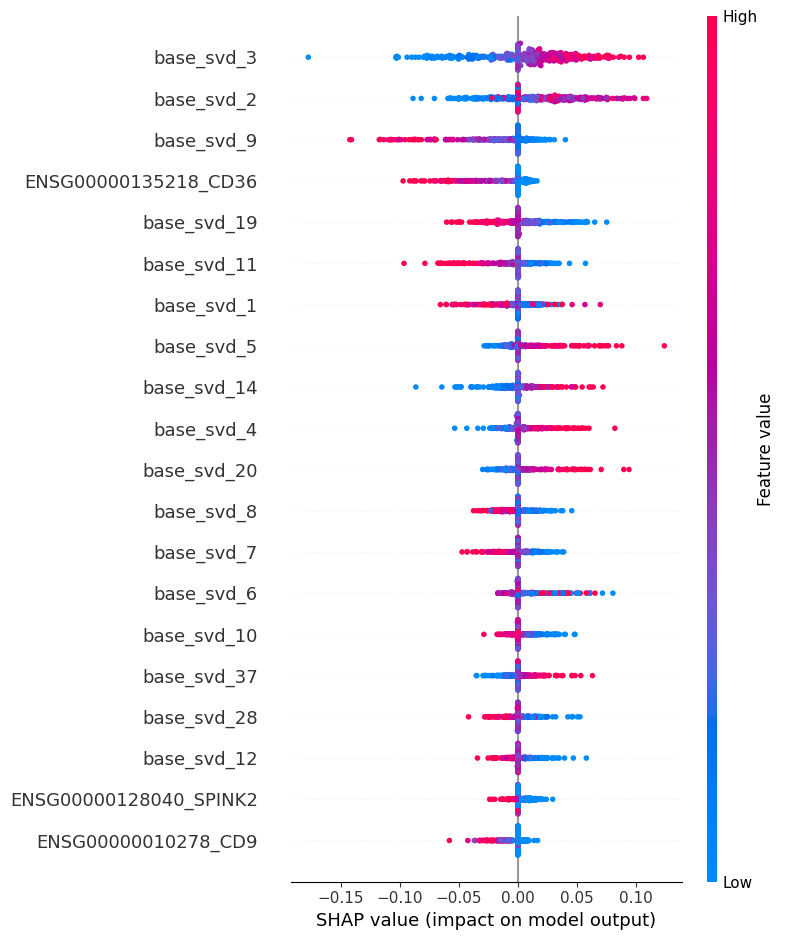

In [5]:
shap.initjs()
shap.summary_plot(shap_values[2], xtest.to_df(), feature_names=xtest.var_names)

In [6]:
def get_top_features(shap_values, xtest, top_n):
    shap_sum = np.abs(shap_values).sum(axis=0)
    top_features_indices = np.argsort(shap_sum)[::-1][:top_n]  # Get the indices of the top n features
    top_feature_names_shap = xtest.var_names[top_features_indices]
    return top_feature_names_shap
get_top_features(shap_values[0], xtest, 20)

Index(['base_svd_2', 'base_svd_9', 'base_svd_1', 'base_svd_16', 'base_svd_11',
       'base_svd_4', 'base_svd_6', 'base_svd_7', 'base_svd_21', 'base_svd_5',
       'ENSG00000135218_CD36', 'base_svd_14', 'base_svd_13',
       'ENSG00000072274_TFRC', 'base_svd_3', 'base_svd_44', 'base_svd_28',
       'base_svd_46', 'base_svd_38', 'ENSG00000117091_CD48'],
      dtype='object')

In [7]:
get_top_features(shap_values[1], xtest, 20)

Index(['base_svd_2', 'base_svd_6', 'base_svd_3', 'ENSG00000135218_CD36',
       'base_svd_4', 'base_svd_20', 'base_svd_5', 'base_svd_18', 'base_svd_16',
       'base_svd_19', 'base_svd_9', 'base_svd_1', 'base_svd_28', 'base_svd_24',
       'base_svd_31', 'base_svd_22', 'base_svd_17', 'base_svd_14',
       'base_svd_10', 'base_svd_13'],
      dtype='object')

In [8]:
get_top_features(shap_values[2], xtest, 20)

Index(['base_svd_3', 'base_svd_2', 'base_svd_9', 'ENSG00000135218_CD36',
       'base_svd_19', 'base_svd_11', 'base_svd_1', 'base_svd_5', 'base_svd_14',
       'base_svd_4', 'base_svd_20', 'base_svd_8', 'base_svd_7', 'base_svd_6',
       'base_svd_10', 'base_svd_37', 'base_svd_28', 'base_svd_12',
       'ENSG00000128040_SPINK2', 'ENSG00000010278_CD9'],
      dtype='object')

In [9]:
get_top_features(shap_values[3], xtest, 20)

Index(['base_svd_9', 'base_svd_1', 'base_svd_13', 'base_svd_25', 'base_svd_3',
       'base_svd_6', 'base_svd_22', 'base_svd_27', 'base_svd_7', 'base_svd_14',
       'base_svd_4', 'base_svd_2', 'base_svd_15', 'ENSG00000135218_CD36',
       'base_svd_18', 'base_svd_30', 'base_svd_12', 'base_svd_39',
       'base_svd_21', 'base_svd_23'],
      dtype='object')

In [7]:
def get_common_elements(attr, xtest, top_features_considered, min_percentage):
    element_counts = {}

    for i in range(140):
        for elt in get_top_features(attr[i], xtest, top_features_considered):
            element_counts[elt] = element_counts.get(elt, 0) + 1

    # Get the elements that appear in at least min_percentage of the lists
    common_elements = {element for element, count in element_counts.items() if count / 140 >= min_percentage}
    return common_elements

get_common_elements(shap_values, xtest, 20, 0.75)

{'ENSG00000135218_CD36',
 'base_svd_1',
 'base_svd_2',
 'base_svd_20',
 'base_svd_3',
 'base_svd_4',
 'base_svd_5',
 'base_svd_6',
 'base_svd_9'}

#### same with attr_all_22085_genes

In [8]:
proteins = np.load('4.model/pred/proteins.npy', allow_pickle=True)
proteins

array(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c',
       'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7', 'CD105', 'CD49f', 'CD194',
       'CD4', 'CD44', 'CD14', 'CD16', 'CD25', 'CD45RO', 'CD279', 'TIGIT',
       'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'CD20',
       'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69', 'CD62L', 'CD161',
       'CD152', 'CD223', 'KLRG1', 'CD27', 'CD107a', 'CD95', 'CD134',
       'HLA-DR', 'CD1c', 'CD11b', 'CD64', 'CD141', 'CD1d', 'CD314',
       'CD35', 'CD57', 'CD272', 'CD278', 'CD58', 'CD39', 'CX3CR1', 'CD24',
       'CD21', 'CD11a', 'CD79b', 'CD244', 'CD169', 'integrinB7', 'CD268',
       'CD42b', 'CD54', 'CD62P', 'CD119', 'TCR', 'Rat-IgG1', 'Rat-IgG2a',
       'CD192', 'CD122', 'FceRIa', 'CD41', 'CD137', 'CD163', 'CD83',
       'CD124', 'CD13', 'CD2', 'CD226', 'CD29', 'CD303', 'CD49b', 'C

In [14]:
print(np.where(proteins == 'CD9'))
print(np.where(proteins == 'CD86'))
print(np.where(proteins == 'CD48'))
print(np.where(proteins == 'CD36'))

(array([121]),)
(array([0]),)
(array([6]),)
(array([113]),)


In [15]:
print(np.where(proteins == 'CD47'))

(array([5]),)


In [11]:
test_inputs = scipy.sparse.load_npz(index_path + "test_cite_raw_inputs_values.sparse.npz")
# test_inputs = pd.DataFrame(test_inputs.toarray(), columns=list(all_22001_genes)+list(handselected_gene_ids))   # order?????? if directly from file probably totally ordered, not 22001+84
test_inputs = pd.DataFrame(test_inputs.toarray(), columns=train_column)   # should be correct order (totally ordered)

# get cell ids
test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_index = test_ids["index"]
len(test_index)

test_inputs.index = test_index

In [12]:
# cell ids used in xtest and SHAP:
sample_cells = xtest.obs_names
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
xtest_all_genes = ad.AnnData(test_inputs.loc[sample_cells])

In [13]:
attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples.pkl')
for i in range(len(attr_all_22085_genes)):
    attr_all_22085_genes[i] = attr_all_22085_genes[i].reindex(columns=train_column)

In [14]:
top_20 = get_top_features(attr_all_22085_genes[0], xtest_all_genes, 20)
top_20

Index(['ENSG00000135218_CD36', 'ENSG00000105472_CLEC11A',
       'ENSG00000072274_TFRC', 'ENSG00000236824_BCYRN1',
       'ENSG00000125148_MT2A', 'ENSG00000183971_NPW', 'ENSG00000244734_HBB',
       'ENSG00000100097_LGALS1', 'ENSG00000184897_H1FX',
       'ENSG00000245532_NEAT1', 'ENSG00000077984_CST7',
       'ENSG00000170891_CYTL1', 'ENSG00000117091_CD48', 'ENSG00000105205_CLC',
       'ENSG00000122862_SRGN', 'ENSG00000124766_SOX4', 'ENSG00000265972_TXNIP',
       'ENSG00000171848_RRM2', 'ENSG00000126264_HCST', 'ENSG00000005381_MPO'],
      dtype='object')

In [15]:
get_top_features(attr_all_22085_genes[2], xtest_all_genes, 20)

Index(['ENSG00000135218_CD36', 'ENSG00000128040_SPINK2', 'ENSG00000010278_CD9',
       'ENSG00000184897_H1FX', 'ENSG00000183971_NPW', 'ENSG00000117091_CD48',
       'ENSG00000100097_LGALS1', 'ENSG00000124766_SOX4',
       'ENSG00000236824_BCYRN1', 'ENSG00000223609_HBD',
       'ENSG00000105472_CLEC11A', 'ENSG00000265972_TXNIP',
       'ENSG00000197061_HIST1H4C', 'ENSG00000188404_SELL',
       'ENSG00000196565_HBG2', 'ENSG00000125148_MT2A', 'ENSG00000105205_CLC',
       'ENSG00000244734_HBB', 'ENSG00000101745_ANKRD12',
       'ENSG00000135655_USP15'],
      dtype='object')

In [16]:
get_top_features(attr_all_22085_genes[3], xtest_all_genes, 20)

Index(['ENSG00000135218_CD36', 'ENSG00000010278_CD9', 'ENSG00000184897_H1FX',
       'ENSG00000072274_TFRC', 'ENSG00000100097_LGALS1', 'ENSG00000223609_HBD',
       'ENSG00000124766_SOX4', 'ENSG00000105205_CLC', 'ENSG00000077984_CST7',
       'ENSG00000105472_CLEC11A', 'ENSG00000183971_NPW',
       'ENSG00000196154_S100A4', 'ENSG00000245532_NEAT1',
       'ENSG00000236824_BCYRN1', 'ENSG00000101745_ANKRD12',
       'ENSG00000265972_TXNIP', 'ENSG00000119865_CNRIP1',
       'ENSG00000135655_USP15', 'ENSG00000128322_IGLL1',
       'ENSG00000197956_S100A6'],
      dtype='object')

In [17]:
get_common_elements(attr_all_22085_genes, xtest_all_genes, 20, 0.75)

{'ENSG00000077984_CST7',
 'ENSG00000100097_LGALS1',
 'ENSG00000101745_ANKRD12',
 'ENSG00000105472_CLEC11A',
 'ENSG00000124766_SOX4',
 'ENSG00000125148_MT2A',
 'ENSG00000135218_CD36',
 'ENSG00000183971_NPW',
 'ENSG00000184897_H1FX',
 'ENSG00000223609_HBD',
 'ENSG00000236824_BCYRN1',
 'ENSG00000245532_NEAT1',
 'ENSG00000265972_TXNIP'}

### cluster the top features of all 140 attr_all_22085_genes[i]

In [18]:
lists = [get_top_features(attr_all_22085_genes[i], xtest_all_genes, 20) for i in range(140)]

In [19]:
from sklearn.cluster import KMeans

similarity_matrix = np.zeros((len(lists), len(lists)))
for i in range(len(lists)):
    for j in range(i+1, len(lists)):
        common_elements = len(set(lists[i]).intersection(lists[j]))
        similarity_matrix[i, j] = common_elements
        similarity_matrix[j, i] = common_elements

# Apply K-means clustering
n_clusters = 4  # Number of clusters to create
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(similarity_matrix)

# Print the cluster labels
for i, label in enumerate(cluster_labels):
    if i < 5:
        print(f"List {i}: Cluster {label}")

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


List 0: Cluster 2
List 1: Cluster 1
List 2: Cluster 1
List 3: Cluster 0
List 4: Cluster 2


In [20]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
# score between -1 and 1, where higher values indicate better-defined and well-separated clusters.
silhouette_avg = silhouette_score(similarity_matrix, cluster_labels)
# highest for 3 or 4 clusters
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.11616598146971178


In [30]:
sc.pp.neighbors(xtest, n_neighbors=10, n_pcs=40)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [33]:
sc.tl.leiden(xtest_all_genes)

In [59]:
sc.tl.paga(xtest_all_genes)
sc.pl.paga(xtest_all_genes, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(xtest_all_genes, init_pos='paga')

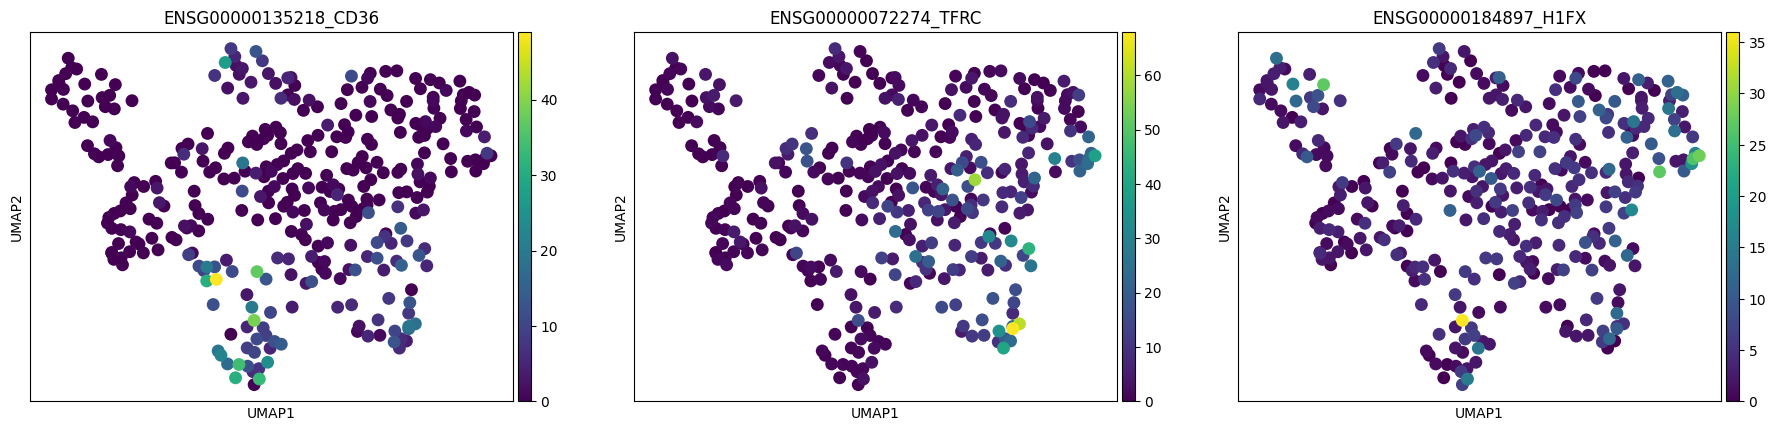

In [55]:
sc.tl.umap(xtest_all_genes)
sc.pl.umap(xtest_all_genes, color=['ENSG00000135218_CD36', 'ENSG00000072274_TFRC', 'ENSG00000184897_H1FX'])


In [56]:
sc.tl.leiden(xtest_all_genes)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


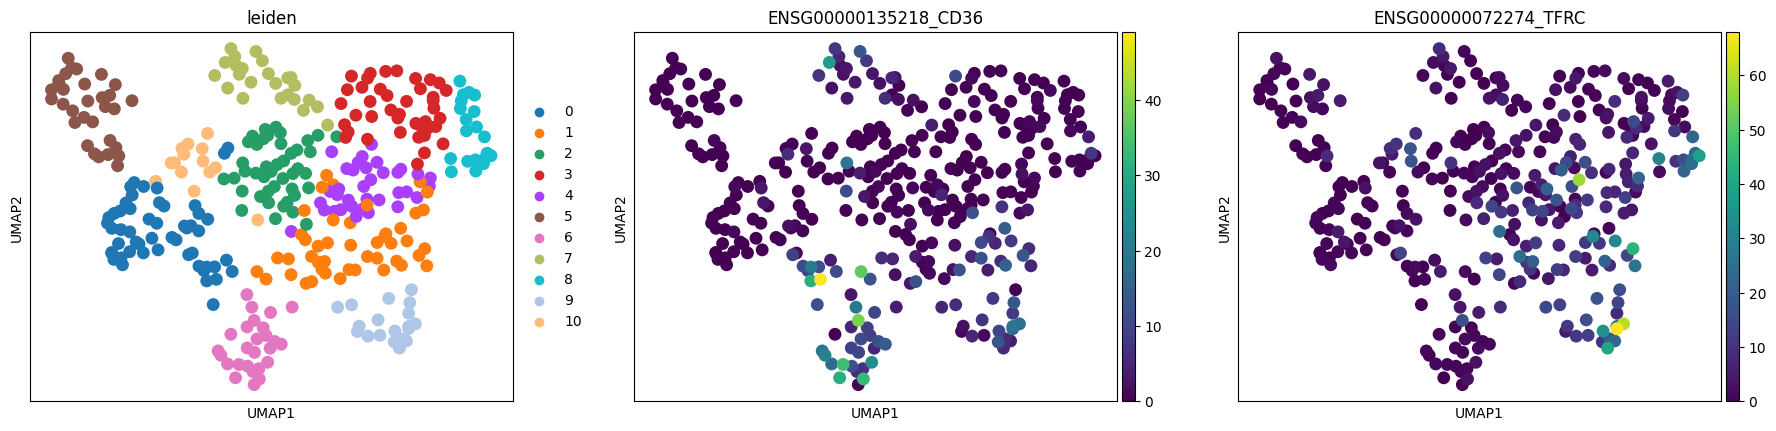

In [57]:
sc.pl.umap(xtest_all_genes, color=['leiden', 'ENSG00000135218_CD36', 'ENSG00000072274_TFRC'])